## Core Idea

Despite a lot of creeping Physics and Chemistry knowledge introduced in the description, this competition is more about Geometry and pattern matching.

The hypothesis of this kernel is next:
1. If we have two similar sets of atoms with the same distances between them and the same types - the scalar coupling constant should be very close.
2. More closest atoms to the pair of atoms under prediction have higher influence on scalar coupling constant then those with higher distance

So, basically, this problem could be dealt with some kind of K-Nearest Neighbor algorithm or any tree-based - e.g. LightGBM, in case we can find some representation which would describe similar configurations with similar feature sets.

Each atom is described with 3 cartesian coordinates. This representation is not stable. Each coupling pair is located in a different point in space and two similar coupling sets would have very different X,Y,Z.

So, instead of using coordinates let's consider next system:
1. Take each pair of atoms as two first core atoms
2. Calculate the center between the pair
3. Find all n-nearest atoms to the center (excluding first two atoms)
4. Take two closest atoms from step 3 - they will be 3rd and 4th core atoms
5. Calculate the distances from 4 core atoms to the rest of the atoms and to the core atoms as well

Using this representation each atom position can be described by 4 distances from the core atoms. This representation is stable to rotation and translation. And it's suitable for pattern-matching. So, we can take a sequence of atoms, describe each by 4 distances + atom type(H,O,etc) and looking up for the same pattern we can find similar configurations and detect scalar coupling constant.

Here I used LightGBM, because sklearn KNN can't deal with the amount of data. My blind guess is that hand-crafted KNN can outperform LightGBM.

Let's code the solution!

## Load Everything

In [1]:
%matplotlib inline

import pandas as pd
import numpy as np

import math
import gc
import copy

from sklearn.model_selection import KFold, train_test_split
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
import seaborn as sns

from lightgbm import LGBMRegressor
import os
# os.listdir('../input/imputed')

In [2]:
DATA_PATH = '..\\input'
SUBMISSIONS_PATH = '..\\output'
# use atomic numbers to recode atomic names
ATOMIC_NUMBERS = {
    'H': 1,
    'C': 6,
    'N': 7,
    'O': 8,
    'F': 9
}

In [3]:
pd.set_option('display.max_colwidth', -1)
pd.set_option('display.max_rows', 120)
pd.set_option('display.max_columns', 120)

## Load Dataset

By default all data is read as `float64` and `int64`. We can trade this uneeded precision for memory and higher prediction speed. So, let's read with Pandas all the data in the minimal representation: 

In [4]:
'{DATA_PATH}\\train.csv'

'{DATA_PATH}\\train.csv'

In [5]:
train_dtypes = {
    'molecule_name': 'category',
    'atom_index_0': 'int8',
    'atom_index_1': 'int8',
    'type': 'category',
    'scalar_coupling_constant': 'float32'
}
train_csv = pd.read_csv(f'{DATA_PATH}\\train.csv', index_col='id', dtype=train_dtypes)
train_csv['molecule_index'] = train_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
train_csv = train_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type', 'scalar_coupling_constant']]
train_csv.head(10)

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,molecule_index,atom_index_0,atom_index_1,type,scalar_coupling_constant
id,,,,,
0,1,1,0,1JHC,84.807602
1,1,1,2,2JHH,-11.257000
2,1,1,3,2JHH,-11.254800
3,1,1,4,2JHH,-11.254300
4,1,2,0,1JHC,84.807404
5,1,2,3,2JHH,-11.254100
6,1,2,4,2JHH,-11.254800
7,1,3,0,1JHC,84.809303
8,1,3,4,2JHH,-11.254300


## Filter

In [51]:
train_csv, _ = train_test_split(train_csv, test_size=0.99, random_state=42)

In [7]:
train_csv.describe()

,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant
count,4.658147e+06,4.658147e+06,4.658147e+06,4.658147e+06
mean,6.915783e+04,1.335689e+01,5.883966e+00,1.589904e+01
std,3.661127e+04,3.267712e+00,4.993943e+00,3.477050e+01
min,1.000000e+00,0.000000e+00,0.000000e+00,-3.621860e+01
25%,3.900200e+04,1.100000e+01,2.000000e+00,-2.549780e-01
50%,7.160900e+04,1.300000e+01,5.000000e+00,2.281130e+00
75%,1.008060e+05,1.600000e+01,8.000000e+00,7.390655e+00
max,1.338840e+05,2.800000e+01,2.800000e+01,2.048800e+02


In [8]:
#imputed_train = pd.read_csv('../input/imputed/imputed_4_correlated_train.csv',dtype = train_dtypes)

#imputed_test = pd.read_csv('../input/imputed/imputed_4_correlated_test.csv',dtype = train_dtypes)
# imputed_test['molecule_index'] = imputed_test.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')

In [9]:
print('Shape: ', train_csv.shape)
print('Total: ', train_csv.memory_usage().sum())
train_csv.memory_usage()

Shape:  (4658147, 5)
Total:  88505177


Index                       37265176
molecule_index              18632588
atom_index_0                4658147 
atom_index_1                4658147 
type                        4658531 
scalar_coupling_constant    18632588
dtype: int64

In [10]:
submission_csv = pd.read_csv(f'{DATA_PATH}\\sample_submission.csv', index_col='id')

C:\ProgramFiles\Anaconda\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [11]:
test_csv = pd.read_csv(f'{DATA_PATH}\\test.csv', index_col='id', dtype=train_dtypes)
test_csv['molecule_index'] = test_csv['molecule_name'].str.replace('dsgdb9nsd_', '').astype('int32')
test_csv = test_csv[['molecule_index', 'atom_index_0', 'atom_index_1', 'type']]
test_csv.head(10)

,molecule_index,atom_index_0,atom_index_1,type
id,,,,
4658147,4,2,0,2JHC
4658148,4,2,1,1JHC
4658149,4,2,3,3JHH
4658150,4,3,0,1JHC
4658151,4,3,1,2JHC
4658152,15,3,0,1JHC
4658153,15,3,2,3JHC
4658154,15,3,4,2JHH
4658155,15,3,5,2JHH


In [12]:
structures_dtypes = {
    'molecule_name': 'category',
    'atom_index': 'int8',
    'atom': 'category',
    'x': 'float32',
    'y': 'float32',
    'z': 'float32'
}
structures_csv = pd.read_csv(f'{DATA_PATH}\\structures.csv', dtype=structures_dtypes)
structures_csv['molecule_index'] = structures_csv.molecule_name.str.replace('dsgdb9nsd_', '').astype('int32')
structures_csv = structures_csv[['molecule_index', 'atom_index', 'atom', 'x', 'y', 'z']]
structures_csv['atom'] = structures_csv['atom'].replace(ATOMIC_NUMBERS).astype('int8')
structures_csv.head(10)

,molecule_index,atom_index,atom,x,y,z
0,1,0,6,-0.012698,1.085804,0.008001
1,1,1,1,0.002150,-0.006031,0.001976
2,1,2,1,1.011731,1.463751,0.000277
3,1,3,1,-0.540815,1.447527,-0.876644
4,1,4,1,-0.523814,1.437933,0.906397
5,2,0,7,-0.040426,1.024108,0.062564
6,2,1,1,0.017257,0.012545,-0.027377
7,2,2,1,0.915789,1.358745,-0.028758
8,2,3,1,-0.520278,1.343532,-0.775543
9,3,0,8,-0.034360,0.977540,0.007602


In [13]:
print('Shape: ', structures_csv.shape)
print('Total: ', structures_csv.memory_usage().sum())
structures_csv.memory_usage()

Shape:  (2358657, 6)
Total:  42455906


Index             80     
molecule_index    9434628
atom_index        2358657
atom              2358657
x                 9434628
y                 9434628
z                 9434628
dtype: int64

## Build Distance Dataset

### Functions

In [14]:
def build_type_dataframes(base, structures, coupling_type):
    base = base[base['type'] == coupling_type].drop('type', axis=1).copy()
    base = base.reset_index()
    base['id'] = base['id'].astype('int32')
    structures = structures[structures['molecule_index'].isin(base['molecule_index'])]
    return base, structures

In [15]:
def add_coordinates(base, structures, index):
    df = pd.merge(base, structures, how='inner',
                  left_on=['molecule_index', f'atom_index_{index}'],
                  right_on=['molecule_index', 'atom_index']).drop(['atom_index'], axis=1)
    df = df.rename(columns={
        'atom': f'atom_{index}',
        'x': f'x_{index}',
        'y': f'y_{index}',
        'z': f'z_{index}'
    })
    return df

In [16]:
def add_atoms(base, atoms):
    df = pd.merge(base, atoms, how='inner',
                  on=['molecule_index', 'atom_index_0', 'atom_index_1'])
    return df

In [17]:
def merge_all_atoms(base, structures):
    df = pd.merge(base, structures, how='left',
                  left_on=['molecule_index'],
                  right_on=['molecule_index'])
    df = df[(df.atom_index_0 != df.atom_index) & (df.atom_index_1 != df.atom_index)]
    return df

In [18]:
def add_center(df):
    df['x_c'] = ((df['x_1'] + df['x_0']) * np.float32(0.5))
    df['y_c'] = ((df['y_1'] + df['y_0']) * np.float32(0.5))
    df['z_c'] = ((df['z_1'] + df['z_0']) * np.float32(0.5))

def add_distance_to_center(df):
    df['d_c'] = ((
        (df['x_c'] - df['x'])**np.float32(2) +
        (df['y_c'] - df['y'])**np.float32(2) + 
        (df['z_c'] - df['z'])**np.float32(2)
    )**np.float32(0.5))

def add_distance_between(df, suffix1, suffix2):
    df[f'd_{suffix1}_{suffix2}'] = ((
        (df[f'x_{suffix1}'] - df[f'x_{suffix2}'])**np.float32(2) +
        (df[f'y_{suffix1}'] - df[f'y_{suffix2}'])**np.float32(2) + 
        (df[f'z_{suffix1}'] - df[f'z_{suffix2}'])**np.float32(2)
    )**np.float32(0.5))

In [19]:
def add_distances(df):
    n_atoms = 1 + max([int(c.split('_')[1]) for c in df.columns if c.startswith('x_')])
    
    for i in range(1, n_atoms):
        for vi in range(min(4, i)):
            add_distance_between(df, i, vi)

In [20]:
def add_n_atoms(base, structures):
    dfs = structures['molecule_index'].value_counts().rename('n_atoms').to_frame()
    return pd.merge(base, dfs, left_on='molecule_index', right_index=True)

In [21]:
def build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=10):
    base, structures = build_type_dataframes(some_csv, structures_csv, coupling_type)
    base = add_coordinates(base, structures, 0)
    base = add_coordinates(base, structures, 1)
    
    base = base.drop(['atom_0', 'atom_1'], axis=1)
    atoms = base.drop('id', axis=1).copy()
    if 'scalar_coupling_constant' in some_csv:
        atoms = atoms.drop(['scalar_coupling_constant'], axis=1)
        
    add_center(atoms)
    atoms = atoms.drop(['x_0', 'y_0', 'z_0', 'x_1', 'y_1', 'z_1'], axis=1)

    atoms = merge_all_atoms(atoms, structures)
    
    add_distance_to_center(atoms)
    
    atoms = atoms.drop(['x_c', 'y_c', 'z_c', 'atom_index'], axis=1)
    atoms.sort_values(['molecule_index', 'atom_index_0', 'atom_index_1', 'd_c'], inplace=True)
    atom_groups = atoms.groupby(['molecule_index', 'atom_index_0', 'atom_index_1'])
    atoms['num'] = atom_groups.cumcount() + 2
    atoms = atoms.drop(['d_c'], axis=1)
    atoms = atoms[atoms['num'] < n_atoms]

    atoms = atoms.set_index(['molecule_index', 'atom_index_0', 'atom_index_1', 'num']).unstack()
    atoms.columns = [f'{col[0]}_{col[1]}' for col in atoms.columns]
    atoms = atoms.reset_index()
    
    # downcast back to int8
    for col in atoms.columns:
        if col.startswith('atom_'):
            atoms[col] = atoms[col].fillna(0).astype('int8')
            
    atoms['molecule_index'] = atoms['molecule_index'].astype('int32')
    
    full = add_atoms(base, atoms)
    add_distances(full)
    
    full.sort_values('id', inplace=True)
    
    return full

In [22]:
def take_n_atoms(df, n_atoms, four_start=4):
    labels = []
    for i in range(2, n_atoms):
        label = f'atom_{i}'
        labels.append(label)

    for i in range(n_atoms):
        num = min(i, 4) if i < four_start else 4
        for j in range(num):
            labels.append(f'd_{i}_{j}')
    if 'scalar_coupling_constant' in df:
        labels.append('scalar_coupling_constant')
    output = df[labels]
    atoms_names = list([col for col in output if col.startswith('atom_')])[2:]
    output = output.drop(atoms_names, axis=1)
    return output

In [23]:
def map_atom_info(df, atom_idx):
    structures = structures_csv[['molecule_index', 'atom_index', 'atom']]
    structures = structures_csv
    df = pd.merge(df, structures, how = 'left',
                  left_on  = ['molecule_index', f'atom_index_{atom_idx}'],
                  right_on = ['molecule_index',  'atom_index'])
    df = df.rename(columns={'atom': f'atom_{atom_idx}'});
    #df = df.drop('atom_index', axis=1)    
    return df

### Проверяем, что для каждого типа молекулы только  atom_1 принимает только одно значение

In [24]:
invest0 = map_atom_info(train_csv, 1)
invest0 = invest0[['type','atom_1']]
invest0.groupby(['type']).mean()

,atom_1
type,
1JHC,6
1JHN,7
2JHC,6
2JHH,1
2JHN,7
3JHC,6
3JHH,1
3JHN,7


### Создаем full

In [25]:
%%time
#full = build_couple_dataframe(train_csv, structures_csv, '1JHN', n_atoms=10)
full = build_couple_dataframe(train_csv, structures_csv, '1JHC', n_atoms=10)
#full = map_atom_info(full, 1)
#full['inv_1_0'] = 1 / full.d_1_0
print(full.shape)

(709416, 73)
Wall time: 21 s


## Check Regressions with the smallest type

In [26]:
full.describe()

,id,molecule_index,atom_index_0,atom_index_1,scalar_coupling_constant,x_0,y_0,z_0,x_1,y_1,z_1,atom_2,atom_3,atom_4,atom_5,atom_6,atom_7,atom_8,atom_9,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,y_2,y_3,y_4,y_5,y_6,y_7,y_8,y_9,z_2,z_3,z_4,z_5,z_6,z_7,z_8,z_9,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,d_7_0,d_7_1,d_7_2,d_7_3,d_8_0,d_8_1,d_8_2,d_8_3,d_9_0,d_9_1,d_9_2,d_9_3
count,7.094160e+05,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.000000,709416.00000,709416.000000,709416.000000,709415.000000,709415.000000,709410.000000,709396.000000,709372.000000,709311.000000,709140.000000,709416.000000,709415.000000,709415.000000,709410.000000,709396.000000,709372.000000,709311.000000,709140.000000,709416.000000,709415.000000,709415.000000,709410.000000,709396.000000,709372.000000,709311.000000,709140.000000,709416.000000,709416.000000,709416.000000,709415.000000,709415.000000,709415.000000,709415.000000,709415.000000,709415.000000,709415.000000,709410.000000,709410.000000,709410.000000,709410.000000,709396.000000,709396.000000,709396.000000,709396.000000,709372.000000,709372.000000,709372.000000,709372.000000,709311.000000,709311.000000,709311.000000,709311.000000,709140.000000,709140.000000,709140.000000,709140.000000
mean,2.346858e+06,69578.058287,13.388730,3.355607,94.968468,0.084930,-0.186960,0.058624,0.095544,-0.199277,0.061694,2.571980,4.718922,5.776832,2.685567,3.561376,4.026453,4.10719,4.122326,0.111967,0.106541,0.084288,0.080968,0.099776,0.135041,0.142912,0.144564,-0.124372,-0.100739,-0.386961,-0.444879,-0.398603,-0.417290,-0.409565,-0.372959,0.072624,0.066435,0.048581,0.040361,0.043828,0.057926,0.059869,0.059587,1.095443,1.871908,1.183647,2.070286,1.387729,2.065054,2.251851,1.602644,2.217796,2.183617,2.619035,2.303248,2.891396,2.462768,2.804069,2.442042,2.979257,2.515744,3.013238,2.552886,2.984176,2.604318,3.200961,2.706883,3.081477,2.742830,3.398124,2.878346,3.210233,2.882257
std,1.359750e+06,37015.281650,3.323251,2.648318,18.275101,1.771651,2.153814,1.581590,1.454962,1.858190,1.232565,2.623271,2.590104,1.326641,2.572154,2.778925,2.734745,2.73514,2.738560,1.690667,1.493002,1.330634,1.626443,1.579239,1.542157,1.544754,1.546896,2.071084,1.947840,1.631903,1.868051,1.824541,1.764865,1.747686,1.760580,1.503611,1.282737,1.084407,1.425646,1.384590,1.368298,1.387742,1.382269,0.007275,0.173052,0.153055,0.273218,0.239477,0.287254,0.268561,0.281198,0.354556,0.411910,0.310797,0.252457,0.627021,0.883054,0.389018,0.311447,0.636119,0.901028,0.453425,0.380512,0.679914,0.909643,0.528979,0.471324,0.736467,0.949629,0.595570,0.554995,0.797964,0.985107
min,0.000000e+00,1.000000,1.000000,0.000000,66.600800,-9.234889,-9.494160,-9.134765,-8.677876,-8.432506,-8.439682,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,-9.234889,-9.234889,-7.942035,-7.933076,-7.650790,-7.428946,-7.346387,-8.320175,-8.176111,-8.917476,-8.038531,-9.254405,-8.046621,-7.757037,-8.432506,-8.757621,-9.134765,-9.134765,-8.439682,-7.986579,-8.789131,-9.134765,-7.666615,-8.510275,1.060901,1.718095,1.075856,1.753604,1.083425,1.349824,1.783157,1.091946,1.002356,1.002817,1.370884,1.743561,0.960062,0.959907,1.795043,1.786337,0.960148,0.960187,1.859788,1.860825,0.958607,0.960109,1.905089,1.902652,0.961042,0.964048,1.994327,1.913389,0.960215,0.964586
25%,1.166458e+06,39040.000000,11.000000,1.000000,84.023003,-0.944503,-1.838470,-0.955183,-0.487375,-1.593819,-0.436742,1.000000,1.000000,6.000000,1.000000,1.000000,1.000000,1.00000,1.000000,-0.864300,-0.786560,-0.265143,-0.976825,-0.942966,-0.879103,-0.862868,-0.839235,-1.704866,-1.622427,-1.396758,-1.606854,-1.535296,-1.543608,-1.634852,-1.633785,-0.924154,-0.749633,-0.205625,-0.908479,-0.919701,-0.913133,-0.914815,-0.887854,1.090297,1.767722,1.093475,1.780717,1.096039,1.774709,2.162195,1.514939,2

We don't calculate distances for `d_0_x`, `d_1_1`, `d_2_2`, `d_2_3`, `d_3_3` because we already have them in later atoms(`d_0_1` == `d_1_0`) or they are equal to zeros(e.g. `d_1_1`, `d_2_2`).

In [27]:
df = take_n_atoms(full, 7)
df.head()


,atom_2,atom_3,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,1.091953,1.783120,1.091952,1.783147,1.091946,1.783157,1.783157,1.091948,1.783148,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.807602
1,1,1,1.091952,1.783120,1.091953,1.783148,1.091948,1.783157,1.783157,1.091946,1.783147,1.783148,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.807404
2,1,1,1.091946,1.783148,1.091948,1.783147,1.091953,1.783157,1.783157,1.091952,1.783148,1.783120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.809303
3,1,1,1.091948,1.783148,1.091946,1.783148,1.091952,1.783157,1.783157,1.091953,1.783147,1.783120,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,84.809502
4,7,0,1.066598,2.218346,1.151748,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,171.220001


For experiments, full dataset can be built with higher number of atoms, and for building a training/validation sets we can trim them:

In [28]:
df = take_n_atoms(full, 7)


#inverse of distances
#filter_col = [col for col in df if col.startswith('d_')]
#df[filter_col] = 1 / (df[filter_col])
#df.head()

# LightGBM performs better with 0-s then with NaN-s
df = df.fillna(0)
df.columns

Index(['atom_2', 'atom_3', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2',
       'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')

In [29]:
df.head()

,atom_2,atom_3,d_1_0,d_2_0,d_2_1,d_3_0,d_3_1,d_3_2,d_4_0,d_4_1,d_4_2,d_4_3,d_5_0,d_5_1,d_5_2,d_5_3,d_6_0,d_6_1,d_6_2,d_6_3,scalar_coupling_constant
0,1,1,1.091953,1.783120,1.091952,1.783147,1.091946,1.783157,1.783157,1.091948,1.783148,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.807602
1,1,1,1.091952,1.783120,1.091953,1.783148,1.091948,1.783157,1.783157,1.091946,1.783147,1.783148,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.807404
2,1,1,1.091946,1.783148,1.091948,1.783147,1.091953,1.783157,1.783157,1.091952,1.783148,1.783120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.809303
3,1,1,1.091948,1.783148,1.091946,1.783148,1.091952,1.783157,1.783157,1.091953,1.783147,1.783120,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,84.809502
4,7,0,1.066598,2.218346,1.151748,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,171.220001


In [31]:
#X_data = df.drop(['scalar_coupling_constant'], axis=1).values.astype('float32')
#y_data = df['scalar_coupling_constant'].values.astype('float32')
X_data = df.drop(['scalar_coupling_constant'], axis=1)
y_data = df['scalar_coupling_constant']


X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=0.2, random_state=128)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((567532, 20), (141884, 20), (567532,), (141884,))

## CatBoost

In [32]:
from catboost import CatBoostRegressor



In [33]:
CAT_PARAMS = {
          'learning_rate': 1,
           'max_depth': 3,    
           'n_estimators': 1000
         }
#categorical features

categorical_features = [col for col in X_train if col.startswith('atom_')]
model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
          cat_features = categorical_features,
          use_best_model=True,
          verbose=True)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

0:	learn: 94.4626077	test: 94.5304159	best: 94.5304159 (0)	total: 148ms	remaining: 44.4s
1:	learn: 93.9626289	test: 94.0304372	best: 94.0304372 (1)	total: 241ms	remaining: 35.9s
2:	learn: 93.4626500	test: 93.5304582	best: 93.5304582 (2)	total: 319ms	remaining: 31.6s
3:	learn: 92.9626658	test: 93.0304733	best: 93.0304733 (3)	total: 395ms	remaining: 29.2s
4:	learn: 92.4626869	test: 92.5304945	best: 92.5304945 (4)	total: 472ms	remaining: 27.8s
5:	learn: 91.9627080	test: 92.0305158	best: 92.0305158 (5)	total: 548ms	remaining: 26.8s
6:	learn: 91.4627262	test: 91.5305325	best: 91.5305325 (6)	total: 639ms	remaining: 26.8s
7:	learn: 90.9627473	test: 91.0305536	best: 91.0305536 (7)	total: 714ms	remaining: 26s
8:	learn: 90.4627685	test: 90.5305748	best: 90.5305748 (8)	total: 786ms	remaining: 25.4s
9:	learn: 89.9627896	test: 90.0305960	best: 90.0305960 (9)	total: 863ms	remaining: 25s
10:	learn: 89.4628088	test: 89.5306147	best: 89.5306147 (10)	total: 938ms	remaining: 24.6s
11:	learn: 88.9628246	t

92:	learn: 48.4635465	test: 48.5313512	best: 48.5313512 (92)	total: 5.71s	remaining: 12.7s
93:	learn: 47.9635518	test: 48.0313565	best: 48.0313565 (93)	total: 5.75s	remaining: 12.6s
94:	learn: 47.4635571	test: 47.5313618	best: 47.5313618 (94)	total: 5.79s	remaining: 12.5s
95:	learn: 46.9635624	test: 47.0313671	best: 47.0313671 (95)	total: 5.82s	remaining: 12.4s
96:	learn: 46.4635677	test: 46.5313724	best: 46.5313724 (96)	total: 5.86s	remaining: 12.3s
97:	learn: 45.9635730	test: 46.0313777	best: 46.0313777 (97)	total: 5.91s	remaining: 12.2s
98:	learn: 45.4635783	test: 45.5313829	best: 45.5313829 (98)	total: 5.95s	remaining: 12.1s
99:	learn: 44.9635835	test: 45.0313882	best: 45.0313882 (99)	total: 5.99s	remaining: 12s
100:	learn: 44.4635888	test: 44.5313935	best: 44.5313935 (100)	total: 6.03s	remaining: 11.9s
101:	learn: 43.9635941	test: 44.0313988	best: 44.0313988 (101)	total: 6.07s	remaining: 11.8s
102:	learn: 43.4635994	test: 43.5314041	best: 43.5314041 (102)	total: 6.12s	remaining: 1

182:	learn: 9.7663549	test: 9.8249447	best: 9.8249447 (182)	total: 11.3s	remaining: 7.21s
183:	learn: 9.6297710	test: 9.6878552	best: 9.6878552 (183)	total: 11.4s	remaining: 7.16s
184:	learn: 9.4965850	test: 9.5544032	best: 9.5544032 (184)	total: 11.4s	remaining: 7.11s
185:	learn: 9.3664600	test: 9.4239508	best: 9.4239508 (185)	total: 11.5s	remaining: 7.06s
186:	learn: 9.2385878	test: 9.2956690	best: 9.2956690 (186)	total: 11.6s	remaining: 7s
187:	learn: 9.1124770	test: 9.1692195	best: 9.1692195 (187)	total: 11.7s	remaining: 6.94s
188:	learn: 8.9872872	test: 9.0435571	best: 9.0435571 (188)	total: 11.7s	remaining: 6.89s
189:	learn: 8.8642144	test: 8.9200183	best: 8.9200183 (189)	total: 11.8s	remaining: 6.85s
190:	learn: 8.7413409	test: 8.7968613	best: 8.7968613 (190)	total: 11.9s	remaining: 6.8s
191:	learn: 8.6204290	test: 8.6753775	best: 8.6753775 (191)	total: 12s	remaining: 6.74s
192:	learn: 8.5030641	test: 8.5574100	best: 8.5574100 (192)	total: 12.1s	remaining: 6.69s
193:	learn: 8.38

275:	learn: 3.8638565	test: 3.8886704	best: 3.8886704 (275)	total: 18s	remaining: 1.57s
276:	learn: 3.8487261	test: 3.8731905	best: 3.8731905 (276)	total: 18.1s	remaining: 1.5s
277:	learn: 3.8343751	test: 3.8586356	best: 3.8586356 (277)	total: 18.1s	remaining: 1.44s
278:	learn: 3.8205636	test: 3.8446666	best: 3.8446666 (278)	total: 18.2s	remaining: 1.37s
279:	learn: 3.8063411	test: 3.8301191	best: 3.8301191 (279)	total: 18.2s	remaining: 1.3s
280:	learn: 3.7932530	test: 3.8165964	best: 3.8165964 (280)	total: 18.3s	remaining: 1.24s
281:	learn: 3.7801021	test: 3.8033478	best: 3.8033478 (281)	total: 18.4s	remaining: 1.17s
282:	learn: 3.7681947	test: 3.7913970	best: 3.7913970 (282)	total: 18.4s	remaining: 1.1s
283:	learn: 3.7497976	test: 3.7728724	best: 3.7728724 (283)	total: 18.5s	remaining: 1.04s
284:	learn: 3.7370771	test: 3.7599152	best: 3.7599152 (284)	total: 18.5s	remaining: 975ms
285:	learn: 3.7254565	test: 3.7478138	best: 3.7478138 (285)	total: 18.6s	remaining: 911ms
286:	learn: 3.7

1.2727094593540142

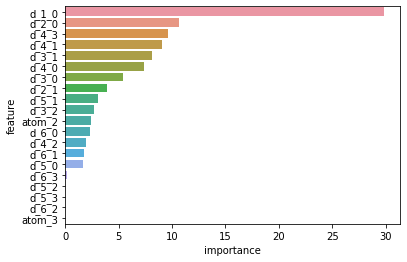

In [35]:
cols = list(X_train.columns)
#cols.remove('scalar_coupling_constant')
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

## LGBMRegressor

In [36]:
#aaa

In [37]:
# configuration params are copied from @artgor kernel:
# https://www.kaggle.com/artgor/brute-force-feature-engineering
if False:
    LGB_PARAMS = {
        'objective': 'regression',
        'metric': 'mae',
        'verbosity': -1,
        'boosting_type': 'gbdt',
        'learning_rate': 0.2,
        'num_leaves': 128,
        'min_child_samples': 79,
        'max_depth': 9,
        'subsample_freq': 1,
        'subsample': 0.9,
        'bagging_seed': 11,
        'reg_alpha': 0.1,
        'reg_lambda': 0.3,
        'colsample_bytree': 1.0
    }
LGB_PARAMS = {
    'objective': 'regression',
    'metric': 'mae',
    'verbosity': -1,
    'boosting_type': 'gbdt',
    'learning_rate': 0.2,
    'num_leaves': 30,
    'min_child_samples': 79,
    'max_depth': 2,
    'subsample_freq': 1,
    'subsample': 0.9,
    'bagging_seed': 11,
    'reg_alpha': 0.1,
    'reg_lambda': 0.3,
    'colsample_bytree': 1.0
}

In [38]:
model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
model.fit(X_train, y_train, 
        eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
        verbose=100, early_stopping_rounds=200)

y_pred = model.predict(X_val)
np.log(mean_absolute_error(y_val, y_pred))

Training until validation scores don't improve for 200 rounds.
[100]	training's l1: 2.67905	valid_1's l1: 2.68189
[200]	training's l1: 2.40368	valid_1's l1: 2.40733
[300]	training's l1: 2.25171	valid_1's l1: 2.25526
[400]	training's l1: 2.15396	valid_1's l1: 2.15851
[500]	training's l1: 2.08047	valid_1's l1: 2.08717
[600]	training's l1: 2.02277	valid_1's l1: 2.02981
[700]	training's l1: 1.97668	valid_1's l1: 1.98508
[800]	training's l1: 1.94122	valid_1's l1: 1.95005
[900]	training's l1: 1.90758	valid_1's l1: 1.91772
[1000]	training's l1: 1.87872	valid_1's l1: 1.88966
[1100]	training's l1: 1.85524	valid_1's l1: 1.86677
[1200]	training's l1: 1.83299	valid_1's l1: 1.84464
[1300]	training's l1: 1.81391	valid_1's l1: 1.82643
[1400]	training's l1: 1.79532	valid_1's l1: 1.80821
[1500]	training's l1: 1.7808	valid_1's l1: 1.79436
[1600]	training's l1: 1.76548	valid_1's l1: 1.77922
[1700]	training's l1: 1.75211	valid_1's l1: 1.76666
[1800]	training's l1: 1.7383	valid_1's l1: 1.75346
[1900]	train

0.4203101925740215

Not a bad score for such a simple set of features.

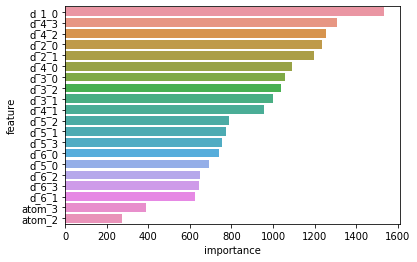

In [40]:
cols = list(df.columns)
cols.remove('scalar_coupling_constant')
cols
df_importance = pd.DataFrame({'feature': cols, 'importance': model.feature_importances_})
sns.barplot(x="importance", y="feature", data=df_importance.sort_values('importance', ascending=False));

It's funny, but looks like atom types aren't used a lot in the final decision. Quite a contrary to what a man would do.

## Submission Model


In [41]:
def build_x_y_data(some_csv, coupling_type, n_atoms):
    full = build_couple_dataframe(some_csv, structures_csv, coupling_type, n_atoms=n_atoms)
    
    df = take_n_atoms(full, n_atoms)
    df = df.fillna(0)
    print(df.columns)
    
    if 'scalar_coupling_constant' in df:
        X_data = df.drop(['scalar_coupling_constant'], axis=1)
        y_data = df['scalar_coupling_constant']
    else:
        X_data = df
        y_data = None
    
    return X_data, y_data

In [42]:
def train_and_predict_for_one_coupling_type(coupling_type, submission, n_atoms, n_folds=5, n_splits=5, random_state=128):
    model_type =  'cat' #lgb 
    print(f'*** Training Model for {coupling_type} ***')
    
    X_data, y_data = build_x_y_data(train_csv, coupling_type, n_atoms)
    columns = X_data.columns 
    X_test, _ = build_x_y_data(test_csv, coupling_type, n_atoms)
    y_pred = np.zeros(X_test.shape[0], dtype='float32')

    cv_score = 0
    
    if n_folds > n_splits:
        n_splits = n_folds
    
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

    for fold, (train_index, val_index) in enumerate(kfold.split(X_data, y_data)):
        if fold >= n_folds:
            break

        #X_train, X_val = X_data[train_index], X_data[val_index]
        #y_train, y_val = y_data[train_index], y_data[val_index]
        X_train, X_val = X_data[columns].iloc[train_index], X_data[columns].iloc[val_index]
        y_train, y_val = y_data.iloc[train_index], y_data.iloc[val_index]

        model = ""
        if model_type == 'lgb':
            model = LGBMRegressor(**LGB_PARAMS, n_estimators=600, n_jobs = -1)
            #model = LGBMRegressor(**LGB_PARAMS, n_estimators=6000, n_jobs = -1)
            model.fit(X_train, y_train, 
                eval_set=[(X_train, y_train), (X_val, y_val)], eval_metric='mae',
                verbose=100, early_stopping_rounds=200)
        
        if model_type == 'cat': 
            categorical_features = [col for col in X_train if col.startswith('atom_')]
            model = CatBoostRegressor(eval_metric='MAE', **CAT_PARAMS, loss_function='MAE')
            X_trainGlob = X_train
            model.fit(X_train, y_train, eval_set=((X_val, y_val)), 
                      cat_features = categorical_features,
                      use_best_model=True,
                      verbose=False)

        y_val_pred = model.predict(X_val)
        val_score = np.log(mean_absolute_error(y_val, y_val_pred))
        print(f'{coupling_type} Fold {fold}, logMAE: {val_score}')
        
        cv_score += val_score / n_folds
        y_pred += model.predict(X_test) / n_folds
        
        
    submission.loc[test_csv['type'] == coupling_type, 'scalar_coupling_constant'] = y_pred
    return cv_score

In [43]:
categorical_features

['atom_2', 'atom_3']

Let's build a separate model for each type of coupling. Dataset is split into 5 pieces and in this kernel we will use only 3 folds for speed up.

Main tuning parameter is the number of atoms. I took good numbers, but accuracy can be improved a bit by tuning them for each type.

In [45]:
if False: 
    model_params = {
        '1JHC': 10,
        '1JHN': 7,    
        '2JHH': 9,
        '2JHN': 9,
        '2JHC': 9,
        '3JHH': 9,
        '3JHC': 10,
        '3JHN': 10
    }
model_params = {
    '1JHC': 7,
    '1JHN': 7,    
    '2JHH': 7,
    '2JHN': 7,
    '2JHC': 7,
    '3JHH': 7,
    '3JHC': 7,
    '3JHN': 7
}


N_FOLDS = 3
submission = submission_csv.copy()

cv_scores = {}
for coupling_type in model_params.keys():
    cv_score = train_and_predict_for_one_coupling_type(
        coupling_type, submission, n_atoms=model_params[coupling_type], n_folds=N_FOLDS)
    cv_scores[coupling_type] = cv_score

*** Training Model for 1JHC ***
Index(['atom_2', 'atom_3', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2',
       'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2',
       'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3'],
      dtype='object')
1JHC Fold 0, logMAE: 1.2687053532325596
1JHC Fold 1, logMAE: 1.2591294949647442
1JHC Fold 2, logMAE: 1.264878465954005
*** Training Model for 1JHN ***
Index(['atom_2', 'atom_3', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1',
       'd_3_2', 'd_4_0', 'd_4_1', 'd_4_2', 'd_4_3', 'd_5_0', 'd_5_1', 'd_5_2',
       'd_5_3', 'd_6_0', 'd_6_1', 'd_6_2', 'd_6_3',
       'scalar_coupling_constant'],
      dtype='object')
Index(['atom_2', 'atom_3', 'd_1_0', 'd_2_0', 'd_2_1', 'd_3_0', 'd_3_1

Checking cross-validation scores for each type:

In [46]:
pd.DataFrame({'type': list(cv_scores.keys()), 'cv_score': list(cv_scores.values())})

,type,cv_score
0,1JHC,1.264238
1,1JHN,-0.292526
2,2JHH,-0.499140
3,2JHN,-0.602355
4,2JHC,0.059864
5,3JHH,-0.404359
6,3JHC,-0.041773
7,3JHN,-0.722611


And cv mean score:

In [47]:
np.mean(list(cv_scores.values()))

-0.15483279523158106

Sanity check for all cells to be filled with predictions:

In [48]:
submission[submission['scalar_coupling_constant'] == 0].shape

(0, 1)

In [49]:
submission.head(10)

,scalar_coupling_constant
id,
4658147,6.362842
4658148,122.934265
4658149,6.667657
4658150,122.934265
4658151,6.362842
4658152,92.460403
4658153,2.290177
4658154,-7.646389
4658155,-9.945740


In [50]:
submission.to_csv(f'{SUBMISSIONS_PATH}/submission.csv')